In [ ]:
# Code to take videos from a folder and display them with MediaPipe Hands
# Código para tomar videos de una carpeta y mostrarlo con Mediapipe Hands


import cv2
import mediapipe as mp
import os

# Iniciar MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Agregar ruta de los videos
video_folder = r"./videos"

video_files = [f for f in os.listdir(video_folder)]

# Procesar cada video en la carpeta
for video_name in video_files:
    
    video_path = os.path.join(video_folder, video_name)
    cap = cv2.VideoCapture(video_path)

    # Obtener la cantidad de frames del video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video: {video_name} - Total de frames: {total_frames}")

    # Configurar MediaPipe Hands
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        cv2.namedWindow("Procesando", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Procesando", 400, 300)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            # Dibujar los landmarks
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            frame_resized = cv2.resize(frame, (400, 300))
            cv2.imshow("Procesando", frame_resized)

            # Salir si se presiona 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Liberar
    cap.release()
    cv2.destroyAllWindows()

print("Procesamiento completado.")

Video: NOMBRE11.mp4 - Total de frames: 90
Video: Nombre21.mp4 - Total de frames: 90
Video: Nombre21_flipped.mp4 - Total de frames: 90
Video: Nombre22.mp4 - Total de frames: 90
Video: Nombre22_flipped.mp4 - Total de frames: 90
Video: NOMBRE31.mp4 - Total de frames: 90
Video: NOMBRE41.mp4 - Total de frames: 90
Video: NOMBRE51.mp4 - Total de frames: 90
Procesamiento completado.


### LIBRERIAS Y ORB

In [ ]:
# Importing the necessary libraries
# Importación de las librerías necesarias


import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Configuración de MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Parámetros
max_frames = 90
num_keypoints = 21  # Puntos clave por mano


In [ ]:
# Code to extract the landmarks positions from all the videos and save them
#Código para extraer las posiciones de los landmarks de todos los videos y guardarlos


# Función para extraer puntos clave de un video
def extraer_puntos_clave_video(ruta_video):
    cap = cv2.VideoCapture(ruta_video)
    frames_puntos = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado = hands.process(frame_rgb)
        
        puntos = []
        if resultado.multi_hand_landmarks:
            for i in range(2):  # Ambas manos
                if i < len(resultado.multi_hand_landmarks):
                    landmarks = [[lm.x, lm.y, lm.z] for lm in resultado.multi_hand_landmarks[i].landmark]
                    puntos.extend(landmarks)
                else:
                    puntos.extend([[0, 0, 0]] * num_keypoints)
        else:
            puntos.extend([[0, 0, 0]] * num_keypoints * 2)
        
        frames_puntos.append(np.array(puntos).flatten())
        
        if len(frames_puntos) >= max_frames:
            break  
    
    cap.release()
    
    while len(frames_puntos) < max_frames:
        frames_puntos.append(np.zeros((num_keypoints * 2 * 3,)))
    
    return np.array(frames_puntos, dtype=np.float32)

# Procesar videos
def procesar_videos(carpeta):
    datos, etiquetas = [], []
    clases = sorted(os.listdir(carpeta))
    
    for clase in clases:
        carpeta_clase = os.path.join(carpeta, clase)
        videos = [v for v in os.listdir(carpeta_clase)]
        
        for video in videos:
            ruta_video = os.path.join(carpeta_clase, video)
            puntos = extraer_puntos_clave_video(ruta_video)
            datos.append(puntos)
            etiquetas.append(clase)
    
    return np.array(datos, dtype=np.float32), np.array(etiquetas)

# Preprocesar etiquetas
def preprocesar_etiquetas(etiquetas):
    lb = LabelBinarizer()
    etiquetas_one_hot = lb.fit_transform(etiquetas)
    return etiquetas_one_hot, lb.classes_

# Rutas de los videos
# Agregar ruta de los videos
carpeta_entrenamiento = r"./videos"
carpeta_prueba = r"./videos"

# Extraer datos sin data augmentation
datos_entrenamiento, etiquetas_entrenamiento = procesar_videos(carpeta_entrenamiento)
datos_prueba, etiquetas_prueba = procesar_videos(carpeta_prueba)

# Convertir etiquetas a formato one-hot
etiquetas_entrenamiento, clases = preprocesar_etiquetas(etiquetas_entrenamiento)
etiquetas_prueba, _ = preprocesar_etiquetas(etiquetas_prueba)

# Normalización
datos_entrenamiento /= np.max(datos_entrenamiento, axis=(1,2), keepdims=True)
datos_prueba /= np.max(datos_prueba, axis=(1,2), keepdims=True)


In [ ]:
# Display coordinates obtained from the first frames of the first video
# Mostrar coordenadas obtenidas de los primeros frames del primer video


index = 0  # Cambia el índice según el video
puntos_guardados = datos_entrenamiento[index]

# Mostrar dimensiones del tensor
print(f"Forma del tensor: {puntos_guardados.shape}")  

# Verificar si hay información sobre el nombre del video
if isinstance(datos_entrenamiento, dict):  # Si los datos están en un diccionario con nombres de archivo
    video_name = list(datos_entrenamiento.keys())[index]
    print(f"Procesando video: {video_name}")
elif isinstance(datos_entrenamiento, list):  # Si los datos están en una lista
    print(f"Procesando video {index+1} de {len(datos_entrenamiento)}")

# Imprimir coordenadas de los primeros 5 frames
for i, frame in enumerate(puntos_guardados[:5]):  
    print(f"Frame {i+1}:\n{frame.squeeze()}")  



Forma del tensor: (90, 126)
Frame 1:
[ 2.3072827e-01  8.9907533e-01 -5.4030878e-08  2.2035879e-01
  9.2687154e-01 -1.7414198e-03  2.0409071e-01  9.4263005e-01
 -4.7717374e-03  1.9385660e-01  9.5309627e-01 -8.2663372e-03
  1.8770421e-01  9.6083289e-01 -1.2241416e-02  1.8900505e-01
  9.3239081e-01 -9.6144527e-03  1.7501737e-01  9.5320845e-01
 -1.9193413e-02  1.7069992e-01  9.7345489e-01 -2.6166881e-02
  1.7018521e-01  9.9250185e-01 -3.0403648e-02  1.9107436e-01
  9.2839938e-01 -1.3637238e-02  1.7444400e-01  9.4835383e-01
 -2.2599025e-02  1.6969232e-01  9.7156632e-01 -2.7659716e-02
  1.6943680e-01  9.9331623e-01 -3.0836511e-02  1.9575034e-01
  9.2412364e-01 -1.7982490e-02  1.7958455e-01  9.4370568e-01
 -2.5930073e-02  1.7425965e-01  9.6677983e-01 -2.9247575e-02
  1.7266060e-01  9.8745072e-01 -3.0968310e-02  2.0269626e-01
  9.1919798e-01 -2.2406470e-02  1.9105716e-01  9.3719900e-01
 -2.8731188e-02  1.8521583e-01  9.5462465e-01 -3.0775946e-02
  1.8288508e-01  9.7055322e-01 -3.1847607e-02  0

In [ ]:
# Training the model for future classification
# Entrenamiendo del modelo para la futura clasificación


modelo = Sequential([
    LSTM(64, return_sequences=True, input_shape=(max_frames, num_keypoints * 2 * 3)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(len(clases), activation='softmax')
])

# Compilar el modelo
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
modelo.fit(
    datos_entrenamiento, etiquetas_entrenamiento, 
    epochs=80, batch_size=32, 
    validation_data=(datos_prueba, etiquetas_prueba),
    callbacks=[early_stopping]
)

# Evaluación del modelo
puntuacion = modelo.evaluate(datos_prueba, etiquetas_prueba)
print("Pérdida:", puntuacion[0])
print("Precisión:", puntuacion[1])


Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.1606 - loss: 2.2493 - val_accuracy: 0.2625 - val_loss: 2.2060
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3102 - loss: 1.9201 - val_accuracy: 0.2750 - val_loss: 2.0942
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.4123 - loss: 1.7128 - val_accuracy: 0.2750 - val_loss: 1.9739
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4916 - loss: 1.5659 - val_accuracy: 0.4000 - val_loss: 1.8699
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5430 - loss: 1.3628 - val_accuracy: 0.4750 - val_loss: 1.7652
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5560 - loss: 1.2560 - val_accuracy: 0.5375 - val_loss: 1.6077
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5969 - loss: 1.0725 - val_accuracy: 0.5625 - val_loss: 1.5496
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6449 - loss: 0.9471 - val_accuracy: 0.5375 - val_loss: 1.4722

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


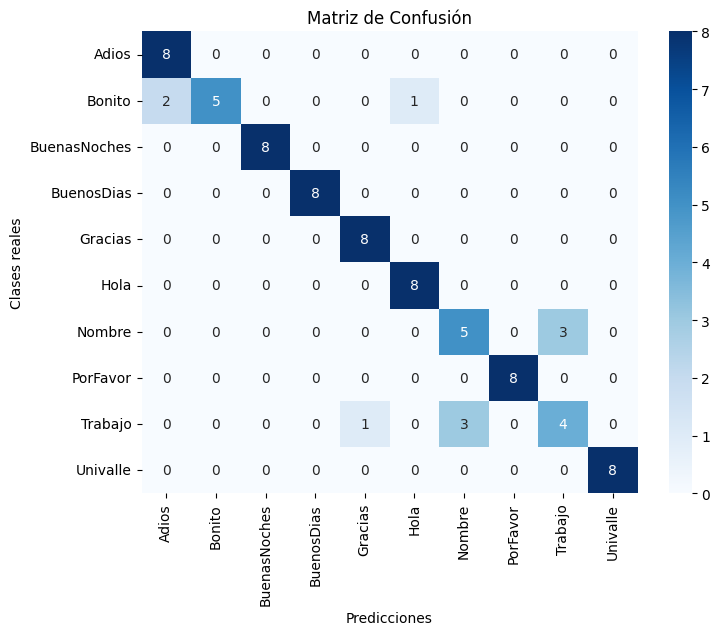

Reporte de clasificación:
              precision    recall  f1-score   support

       Adios       0.80      1.00      0.89         8
      Bonito       1.00      0.62      0.77         8
BuenasNoches       1.00      1.00      1.00         8
  BuenosDias       1.00      1.00      1.00         8
     Gracias       0.89      1.00      0.94         8
        Hola       0.89      1.00      0.94         8
      Nombre       0.62      0.62      0.62         8
    PorFavor       1.00      1.00      1.00         8
     Trabajo       0.57      0.50      0.53         8
    Univalle       1.00      1.00      1.00         8

    accuracy                           0.88        80
   macro avg       0.88      0.88      0.87        80
weighted avg       0.88      0.88      0.87        80



In [ ]:
# Predictions are made and the confusion matrix is observed
# Se realizan las predicciones y se observa la matriz de confusión


# Realizar predicciones
predicciones = modelo.predict(datos_prueba)
predicciones_clases = np.argmax(predicciones, axis=1)
etiquetas_reales = np.argmax(etiquetas_prueba, axis=1)

# Calcular matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_reales, predicciones_clases)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar métricas adicionales
print("Reporte de clasificación:")
print(classification_report(etiquetas_reales, predicciones_clases, target_names=clases))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


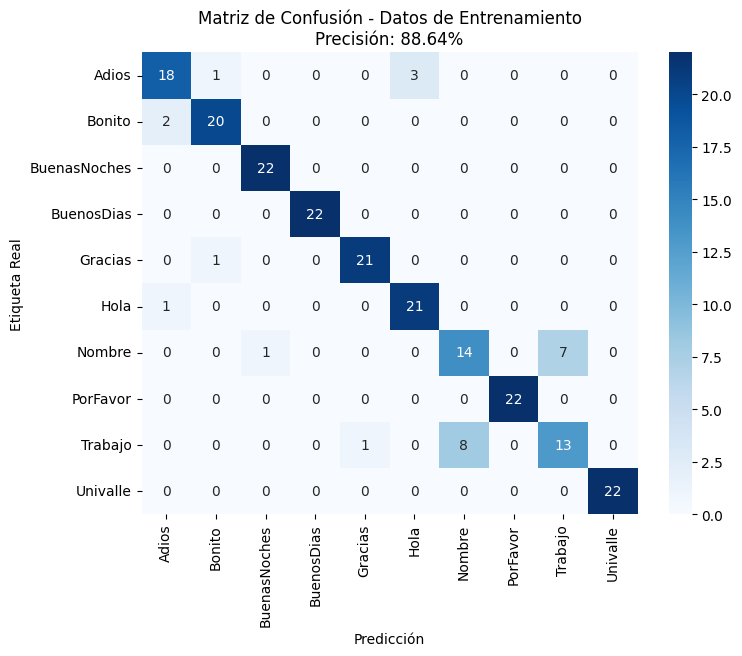

In [ ]:
# Now the confusion matrix of the training data is observed
# Ahora se observa la matriz de confusión de los datos de entrenamiento


# Obtener predicciones del modelo en los datos de entrenamiento
y_pred_train_probs = modelo.predict(datos_entrenamiento)

# Convertir las probabilidades en etiquetas de clase
y_pred_train = np.argmax(y_pred_train_probs, axis=1)
y_true_train = np.argmax(etiquetas_entrenamiento, axis=1)

# Generar la matriz de confusión
conf_matrix_train = confusion_matrix(y_true_train, y_pred_train)

# Calcular precisión
accuracy_train = accuracy_score(y_true_train, y_pred_train)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title(f"Matriz de Confusión - Datos de Entrenamiento\nPrecisión: {accuracy_train:.2%}")
plt.show()


In [ ]:
# Save the obtained model
# Guardar el modelo obtenido


modelo.save("modelo_gestosBDPER.h5")

In [ ]:
# The model is tested with any video
# Se realiza la prueba del modelo con un video cualquiera


# Cargar el modelo
modelo = tf.keras.models.load_model("modelo_gestosBDPER.h5")

# Clases de gestos
clases = ["Adios", "Bonito", "BuenasNoches", "BuenosDias", "Gracias", 
          "Hola", "Nombre", "PorFavor", "Trabajo", "Univalle"]

# Configuración de MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Parámetros
max_frames = 90
num_keypoints = 21  # Puntos clave por mano (se usa hasta 2 manos)

def extraer_puntos_clave_frame(frame):
    """ Extrae los puntos clave de la(s) mano(s) en un frame usando MediaPipe. """
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resultado = hands.process(frame_rgb)
    
    # Inicializar puntos clave en cero (si no se detectan manos)
    puntos = [[0, 0, 0]] * num_keypoints * 2

    if resultado.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(resultado.multi_hand_landmarks[:2]):  # Máximo 2 manos
            for j, landmark in enumerate(hand_landmarks.landmark):
                puntos[i * num_keypoints + j] = [landmark.x, landmark.y, landmark.z]

    return np.array(puntos).flatten()

# Cargar video
# Agregar ruta de los videos
ruta_video = r"./videos"
cap = cv2.VideoCapture(ruta_video)

if not cap.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

print("Video detectado correctamente. Procesando...")

frames_puntos = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    puntos = extraer_puntos_clave_frame(frame)
    frames_puntos.append(puntos)

    # Mantener solo los últimos 90 frames
    if len(frames_puntos) > max_frames:
        frames_puntos.pop(0)

cap.release()
cv2.destroyAllWindows()

# Asegurar que el video tenga exactamente 90 frames
while len(frames_puntos) < max_frames:
    frames_puntos.append(np.zeros(num_keypoints * 2 * 3))  # Vector de ceros si faltan frames

# Convertir a numpy array
datos_video = np.array([frames_puntos], dtype=np.float32)

# Normalizar si en el entrenamiento se normalizó
datos_video /= np.max(datos_video, axis=(1,2), keepdims=True)

# Predicción
prediccion = modelo.predict(datos_video)
gesto_predicho = clases[np.argmax(prediccion)]

print("Gesto detectado:", gesto_predicho)


Video detectado correctamente. Procesando...


C:\Users\Joshua Arango\AppData\Local\Temp\ipykernel_20040\414707074.py:66: RuntimeWarning: invalid value encountered in divide
  datos_video /= np.max(datos_video, axis=(1,2), keepdims=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
Gesto detectado: Adios


In [ ]:
# Test the obtained model with a video recorded at the moment
# Realiza la prueba del modelo obtenido con un video grabado al momento


import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp


modelo = tf.keras.models.load_model("modelo_gestos.h5")
clases = ["Adios", "Bonito", "BuenasNoches", "BuenosDias", "Gracias", 
          "Hola", "Nombre", "PorFavor", "Trabajo", "Univalle"]


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
max_frames = 90
num_keypoints = 21

def extraer_puntos_clave_frame(frame):

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resultado = hands.process(frame_rgb)
    
    # Inicializar puntos clave en cero (si no se detectan manos)
    puntos = [[0, 0, 0]] * num_keypoints * 2

    if resultado.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(resultado.multi_hand_landmarks[:2]): 
            for j, landmark in enumerate(hand_landmarks.landmark):
                puntos[i * num_keypoints + j] = [landmark.x, landmark.y, landmark.z]

    return np.array(puntos).flatten()

# Captura en tiempo real
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo acceder a la cámara.")
    exit()

print("Cámara detectada. Capturando frames (90 en total)...")

frames_puntos = []
frame_count = 0

while frame_count < max_frames:
    ret, frame = cap.read()
    if not ret:
        print("Error al capturar el frame.")
        break

    puntos = extraer_puntos_clave_frame(frame)
    frames_puntos.append(puntos)
    frame_count += 1

    # Mostrar el frame en una ventana
    cv2.imshow("Captura en tiempo real", frame)

    # Salir si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Si no se alcanzaron los 90 frames, rellenar con ceros
while len(frames_puntos) < max_frames:
    frames_puntos.append(np.zeros(num_keypoints * 2 * 3))

# Convertir a numpy array
datos_video = np.array([frames_puntos], dtype=np.float32)

# Normalizar si en el entrenamiento se normalizó
datos_video /= np.max(datos_video, axis=(1,2), keepdims=True)

# Predicción
prediccion = modelo.predict(datos_video)
gesto_predicho = clases[np.argmax(prediccion)]

print("Gesto detectado:", gesto_predicho)
